**Load Art Picies**

Author:Claudia Magliano

Date: 20/01/2025

# Purpose of the Code
The purpose of this code is to get the artpicies files from Google Drive and classify them according to their author. The label is the name of the each file.

In [1]:
#Importing the important libraries
import os
import pathlib
import pandas as pd
import string
import einops
import matplotlib.pyplot as plt
import urllib.request

from google.colab import drive

import requests
import glob
from itertools import groupby
from PIL import Image

In [2]:
# Mount the Google Drive at /content/drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Path to paintings directory
paintings_path = "/content/drive/MyDrive/Artpicies/"

# Extracting artist names
artists_file_path = glob.glob(paintings_path+'/*.jpg')

# Creating Dataframes to suppport analysis and classification of data
Creating 3 dataframes to show a plot with the number of the atrwork of each author and 2 to create a dataframe to be used by the ImageDataLoader.

In [4]:
df_arts = pd.DataFrame()
df_temp = pd.DataFrame()
df_artists = pd.DataFrame()


paths =[]
labels =[]
artists =[]

old_artist_name = " "
num_art = 0
for filename in artists_file_path:
    artist_name = ""
    artist_path = (filename.split("/")[5].split("_"))[0:-1]
    file = (filename.split("/")[5])[0:]

    for item in artist_path:
        artist_name = artist_name + " " + item

    if artist_name.strip() == 'BOTTICELLI':
      label = 0
    elif artist_name.strip() == 'GOGH':
      label = 1
    elif artist_name.strip() == 'MONET':
      label = 2
    else:
      label = 3

    artists.append(artist_name)
    paths.append(file)
    labels.append(label)

df_temp['path'] = paths
df_temp['label']= labels
df_artists['artist'] = artists

df_arts = pd.concat([df_arts,df_temp])
df_artists["contagem"] = df_artists.groupby(["artist"]).transform('size')
df_artists = df_artists.drop_duplicates(subset=['artist'])

In [5]:
df_artists

artist  contagem
0     BOTTICELLI       206
206         GOGH       420
626        MONET       198
824       RENOIR       111

In [6]:
df_arts

path  label
0    BOTTICELLI_1.jpg      0
1    BOTTICELLI_2.jpg      0
2    BOTTICELLI_3.jpg      0
3    BOTTICELLI_4.jpg      0
4    BOTTICELLI_5.jpg      0
..                ...    ...
930    RENOIR_107.jpg      3
931    RENOIR_108.jpg      3
932    RENOIR_109.jpg      3
933    RENOIR_110.jpg      3
934    RENOIR_111.jpg      3

[935 rows x 2 columns]

In [7]:
# Storing frequency of paintings per artist
artist_frequency = df_arts.groupby('label').count()
max = df_arts["label"].value_counts().nlargest(n=1).values[0]
min = df_arts["label"].value_counts().nsmallest(n=1).values[0]

In [8]:
print("Number of Arts: " + str(len(artist_frequency)))
print("Maxmimum Number of Paintigs Per Artist: " + str(max))
print("Minimum Number of Paintigs Per Artitst: " + str(min))

Number of Arts: 4
Maxmimum Number of Paintigs Per Artist: 420
Minimum Number of Paintigs Per Artitst: 111


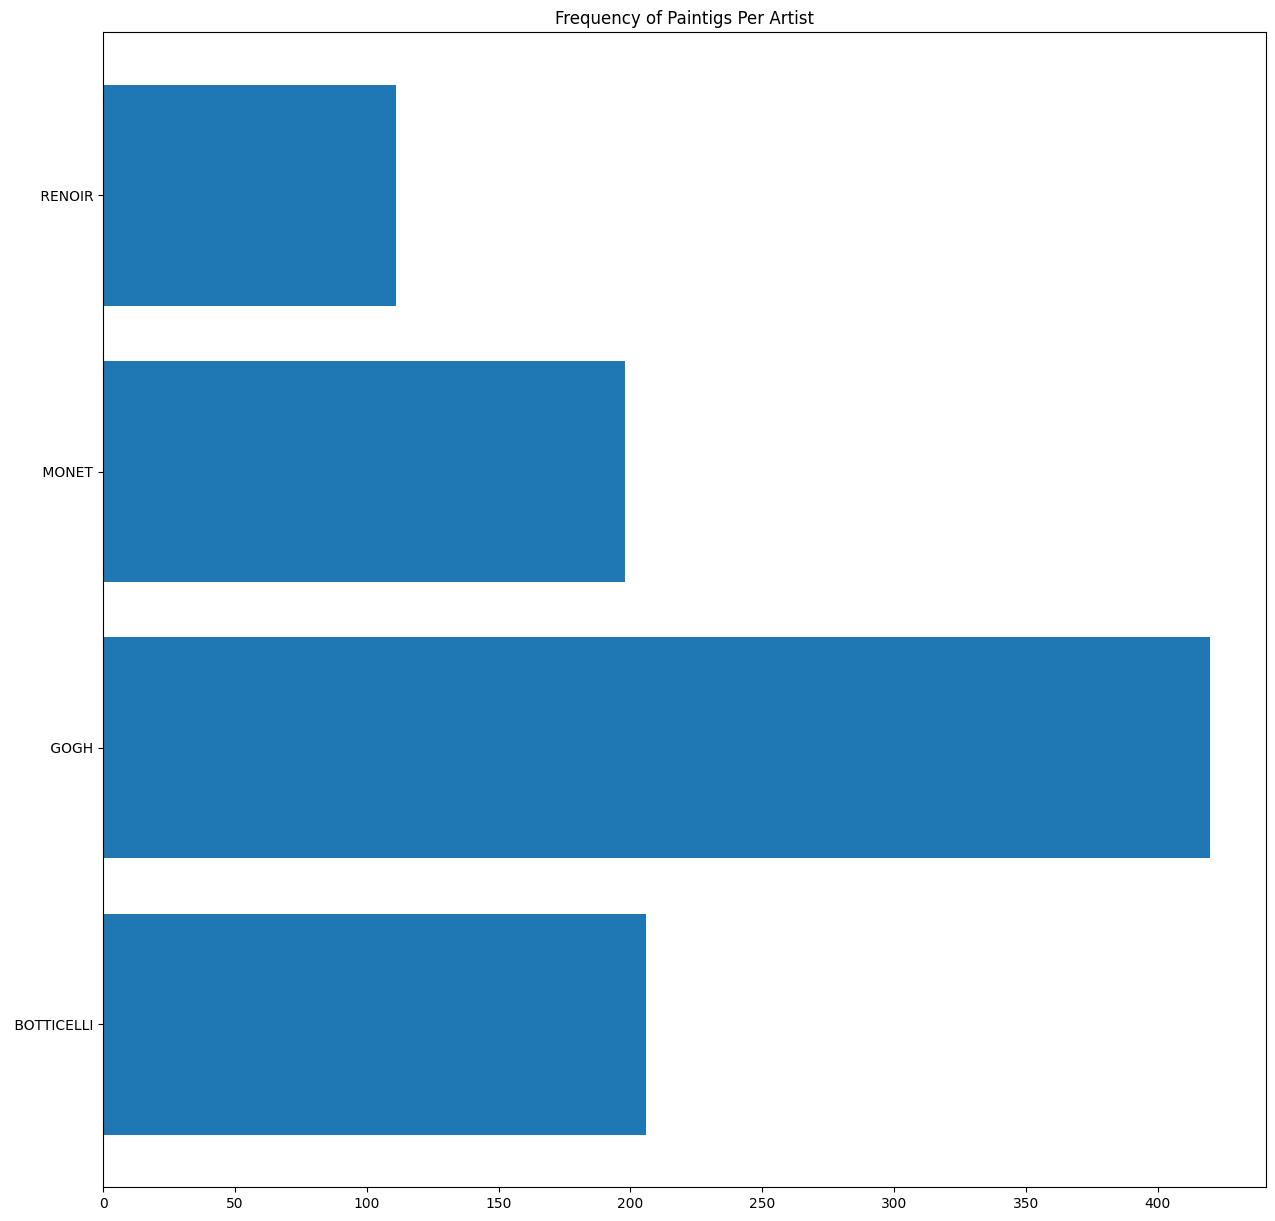

In [9]:
# Horizontal Bar Graph of Frequency of Paintigs Per Artist
artists = df_artists["artist"]
frequency = df_artists["contagem"]

x_pos = df_artists["artist"]

plt.figure(figsize=(15,15))
plt.barh(x_pos, frequency)
plt.title("Frequency of Paintigs Per Artist")

plt.yticks(x_pos, artists)

plt.show()

In [10]:
!!pip install fastai --upgrade -q
import fastai
from fastai.vision.all import *

# Training The Model

In [11]:
item_tfms = [Resize(256)]
inames = get_image_files(paintings_path)

data= ImageDataLoaders.from_name_re(
        path= paintings_path, fnames=inames,pat= r'([A-Z]+)', valid_pct=0.2, seed=42, bs=16,
        item_tfms=item_tfms)

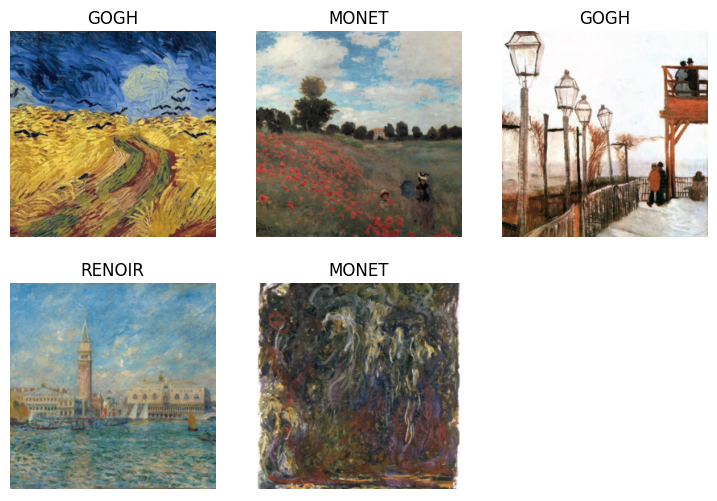

In [12]:
data.valid.show_batch(max_n= 5)

In [13]:
data.vocab

['BOTTICELLI', 'GOGH', 'MONET', 'RENOIR']

# RESNET 152
The next step is to use a transfer lernaning CNN.

In [14]:
# Using resnet152 --> transfer learning
# Metrics --> error_rate,accuracy,mean_squared_error,top_k_accuracy,r2_score
artist_identification = vision_learner(data, models.resnet152, metrics=(error_rate,accuracy),
                                    model_dir='paintings_path')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 171MB/s]


In [15]:
artist_identification.fit_one_cycle(5)

After 5 epochs the model achieves almost 90% of accuracy

In [16]:
artist_identification.save('version_152n_1.0')

Path('/content/drive/MyDrive/Artpicies/paintings_path/version_152n_1.0.pth')

In [17]:
#Initiating refit and checking LR
artist_identification.load('version_152n_1.0')
artist_identification.unfreeze()

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

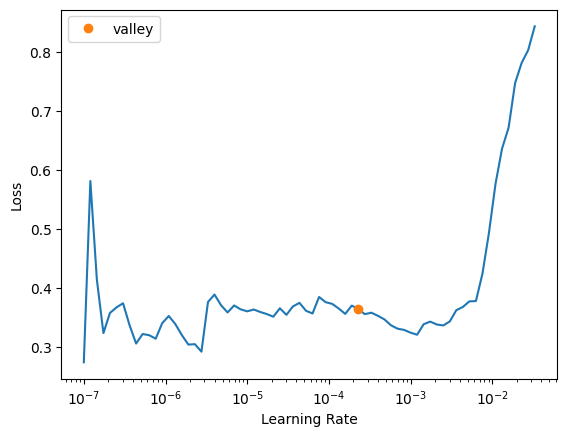

In [18]:
lr_max = artist_identification.lr_find()

In [19]:
#The lowest loss is at 1e-04 and loss increases from after 1e-03. Refitting by modulating LR
artist_identification.fit_one_cycle(2,lr_max=slice(1e-04,1e-03))

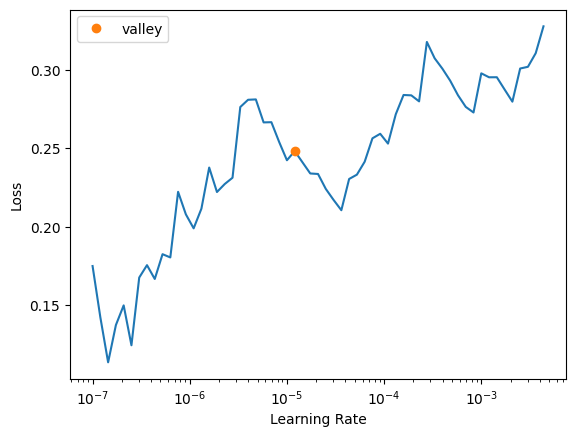

In [20]:
lr_max = artist_identification.lr_find()

In [21]:
#The lowest loss is at 1e-05 and loss increases from after 1e-04. Refitting by modulating LR
artist_identification.fit_one_cycle(2,lr_max=slice(1e-05,1e-04))

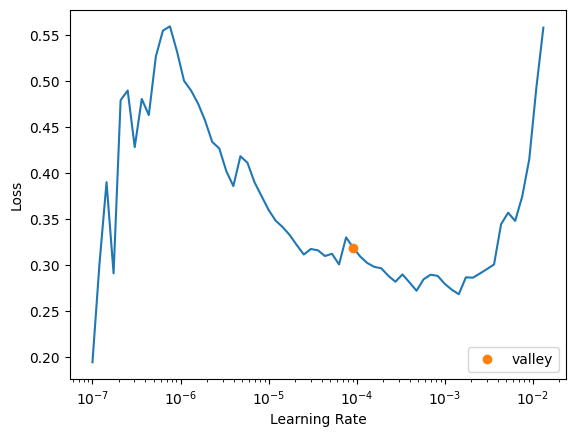

In [ ]:
lr_max = artist_identification.lr_find()

In [22]:
artist_identification.save('version_152n_2.0')

Path('/content/drive/MyDrive/Artpicies/paintings_path/version_152n_2.0.pth')

In [23]:
#The lowest loss is at 1e-04 and loss increases from after 1e-03. Refitting by modulating LR
artist_identification.fit_one_cycle(2,lr_max=slice(1e-04,1e-03))

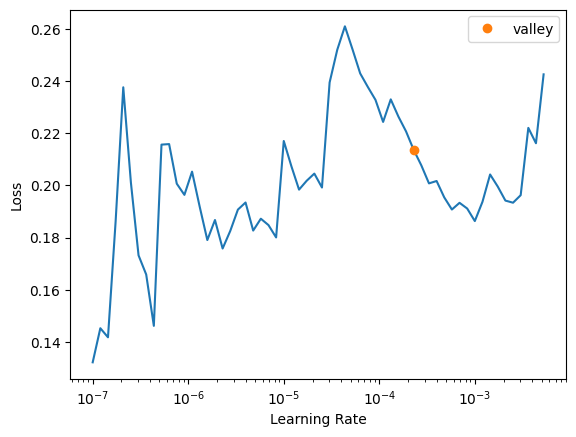

In [25]:
lr_max = artist_identification.lr_find()

In [26]:
#The lowest loss is at 1e-04 and loss increases from after 1e-03. Refitting by modulating LR
artist_identification.fit_one_cycle(2,lr_max=slice(1e-04,1e-03))

In [27]:
artist_identification.save('version_152n_3.0')

Path('/content/drive/MyDrive/Artpicies/paintings_path/version_152n_3.0.pth')

In [28]:
interp = ClassificationInterpretation.from_learner(artist_identification)

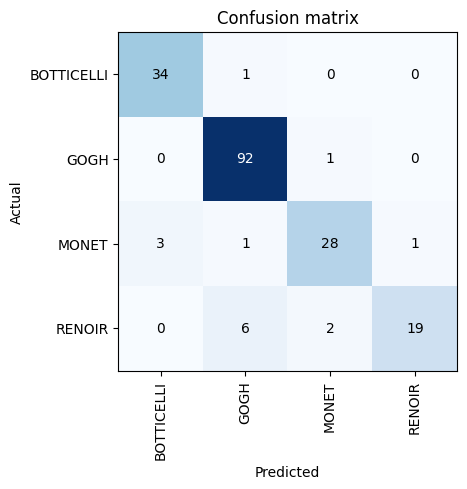

In [29]:
interp.plot_confusion_matrix()

In [30]:
interp.most_confused()

[('RENOIR', 'GOGH', 6),
 ('MONET', 'BOTTICELLI', 3),
 ('RENOIR', 'MONET', 2),
 ('BOTTICELLI', 'GOGH', 1),
 ('GOGH', 'MONET', 1),
 ('MONET', 'GOGH', 1),
 ('MONET', 'RENOIR', 1)]

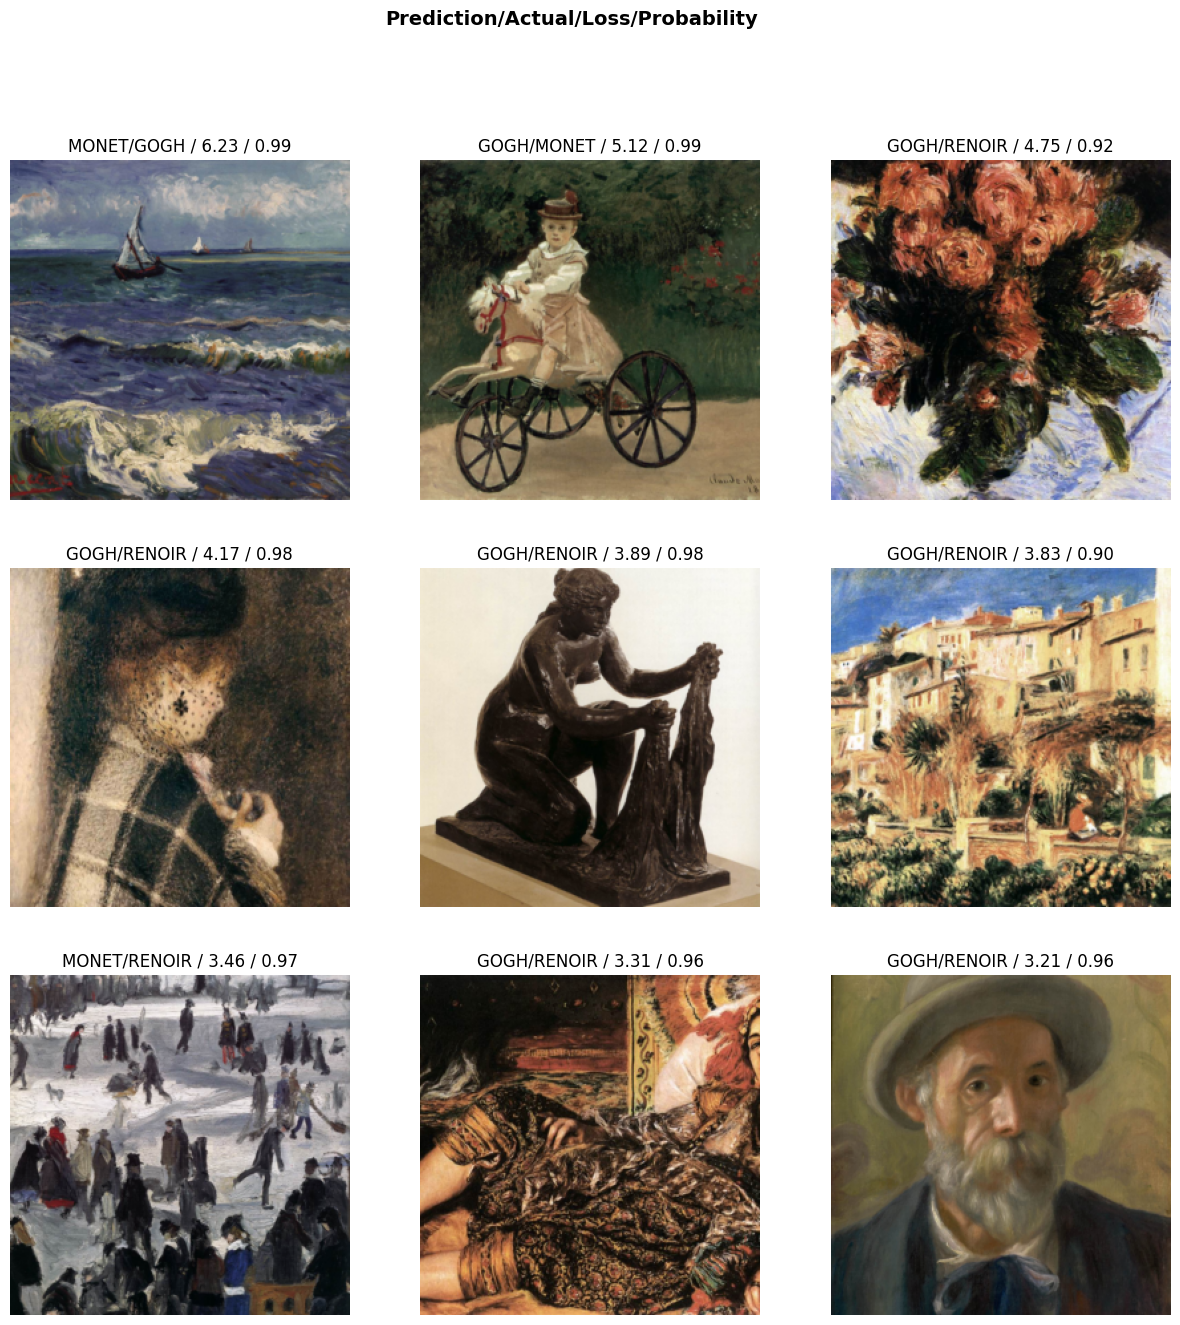

In [31]:
interp.plot_top_losses(9, figsize=(15,15))

In [108]:
images = [('MONET', '/content/drive/MyDrive/Artpicies/paintings_path/MONET.JPG'),
          ('RENOIR', '/content/drive/MyDrive/Artpicies/paintings_path/RENOIR.JPG'),
          ('BOTTICELLI', '/content/drive/MyDrive/Artpicies/paintings_path/BOTTICELLI.JPG')
         ]

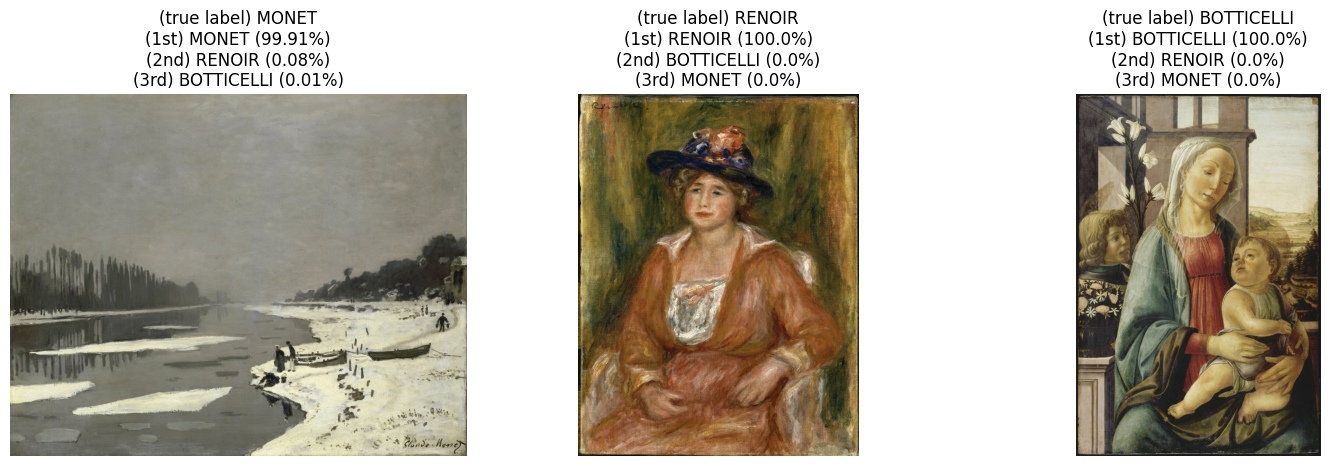

In [123]:
import PIL.Image as Image
ig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('True label / 1st, 2nd and 3rd best predictions', fontsize=16)

for i, image in enumerate(images):

    # Get image
    class_name, img = image[0], image[1]

    img = Image.open(img).convert('RGB')

    # Get best first prediction
    pred_1_class, indice, preds = artist_identification.predict(img)

    # Get all best predictions
    preds_sorted, idxs = preds.sort(descending=True)

    # Get best 3 predictions - classes
    pred_2_class = artist_identification.dls.vocab[idxs[1].item()]
    pred_3_class = artist_identification.dls.vocab[idxs[2].item()]

    # Get best 3 predictions - probabilities
    pred_1_prob = np.round(100*preds_sorted[0].item(),2)
    pred_2_prob = np.round(100*preds_sorted[1].item(),2)
    pred_3_prob = np.round(100*preds_sorted[2].item(),2)
    preds_best3 = [f'{pred_1_class} ({pred_1_prob}%)', f'{pred_2_class} ({pred_2_prob}%)', f'{pred_3_class} ({pred_3_prob}%)']

    # Display images with True label / 1st, 2nd and 3rd best Predictions
    plt.tight_layout()
    img.show(ax=ax[i],
         title=f'(true label) {class_name}\n(1st) {preds_best3[0]}\n(2nd) {preds_best3[1]}\n(3rd) {preds_best3[2]}')
